#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/AIVLE_SCHOOL_5th/언어지능_딥러닝/2024.04.24_미니프로젝트6차_실습자료/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [4]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [10]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


#### 2) 기본 정보 조회

In [ ]:
oil_price.head(), oil_price.shape

(        Date  WTI_Price
 0 2014-01-01        NaN
 1 2014-01-02      95.14
 2 2014-01-03      93.66
 3 2014-01-06      93.12
 4 2014-01-07      93.31,
 (825, 2))

In [ ]:
orders.head(), orders.shape
# CustomerCount: 구매 고객 수

(        Date  Store_ID  CustomerCount
 0 2014-01-01        25            840
 1 2014-01-01        36            487
 2 2014-01-02         1           1875
 3 2014-01-02         2           2122
 4 2014-01-02         3           3350,
 (57558, 3))

In [ ]:
sales.head(), sales.shape

(        Date  Store_ID  Qty  Product_ID
 0 2014-01-01         1  0.0           3
 1 2014-01-01         1  0.0           5
 2 2014-01-01         1  0.0           7
 3 2014-01-01         1  0.0           8
 4 2014-01-01         1  0.0          10,
 (934275, 4))

In [ ]:
products.head(), products.shape

(   Product_ID Product_Code      SubCategory         Category  LeadTime  Price
 0          20        HG001  Gardening Tools  Household Goods         2     50
 1          27        HH001  Home Appliances  Household Goods         2    150
 2          16        HK001          Kitchen  Household Goods         2     23
 3          15        HK002          Kitchen  Household Goods         2     41
 4          32        GS001          Seafood          Grocery         3     34,
 (16, 6))

In [ ]:
stores.head(), stores.shape

(   Store_ID           City        State  Store_Type
 0         1     Saint Paul  \tMinnesota           4
 1         2     Saint Paul  \tMinnesota           4
 2         3     Saint Paul  \tMinnesota           4
 3         4     Saint Paul  \tMinnesota           4
 4         5  Oklahoma City     Oklahoma           4,
 (54, 4))

In [ ]:
df_order = pd.merge(orders, stores)
df_order

,Date,Store_ID,CustomerCount,City,State,Store_Type
0,2014-01-01,25,840,Olympia,Washington,4
1,2014-01-02,25,1315,Olympia,Washington,4
2,2014-01-03,25,1433,Olympia,Washington,4
3,2014-01-04,25,1613,Olympia,Washington,4
4,2014-01-05,25,878,Olympia,Washington,4
...,...,...,...,...,...,...
57553,2017-02-24,22,734,LA,\tCalifornia,3
57554,2017-02-25,22,735,LA,\tCalifornia,3
57555,2017-02-26,22,720,LA,\tCalifornia,3
57556,2017-02-27,22,672,LA,\tCalifornia,3


In [ ]:
df_sales = pd.merge(sales, products)
# df_sales = pd.merge(df_sales, oil_price, on='Date')
df_sales

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8
1,2014-01-01,2,0.0,3,DB001,Beverage,Drink,2,8
2,2014-01-01,3,0.0,3,DB001,Beverage,Drink,2,8
3,2014-01-01,4,0.0,3,DB001,Beverage,Drink,2,8
4,2014-01-01,5,0.0,3,DB001,Beverage,Drink,2,8
...,...,...,...,...,...,...,...,...,...
934270,2017-02-24,44,91.0,42,FM001,Agricultural products,Grocery,2,5
934271,2017-02-25,44,105.0,42,FM001,Agricultural products,Grocery,2,5
934272,2017-02-26,44,108.0,42,FM001,Agricultural products,Grocery,2,5
934273,2017-02-27,44,78.0,42,FM001,Agricultural products,Grocery,2,5


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
# 대상 매장: 44, 대상 상품: 3, 12, 42
Product_ID = 3
sales_tar = df_sales.loc[(df_sales['Store_ID'] == 44) & (df_sales['Product_ID'] == Product_ID)]
sales_tar.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
43,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8
97,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8
151,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8
205,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8
259,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8


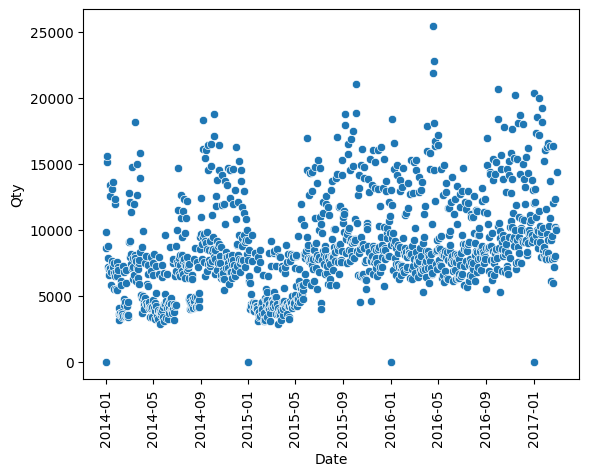

In [ ]:
sns.scatterplot(data=sales_tar, x='Date', y='Qty')
plt.xticks(rotation=90)
plt.show()

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [ ]:
df_sales.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8
1,2014-01-01,2,0.0,3,DB001,Beverage,Drink,2,8
2,2014-01-01,3,0.0,3,DB001,Beverage,Drink,2,8
3,2014-01-01,4,0.0,3,DB001,Beverage,Drink,2,8
4,2014-01-01,5,0.0,3,DB001,Beverage,Drink,2,8


In [ ]:
sales_tar['Category'].value_counts(), sales_tar['SubCategory'].value_counts()

(Category
 Drink    1152
 Name: count, dtype: int64,
 SubCategory
 Beverage    1152
 Name: count, dtype: int64)

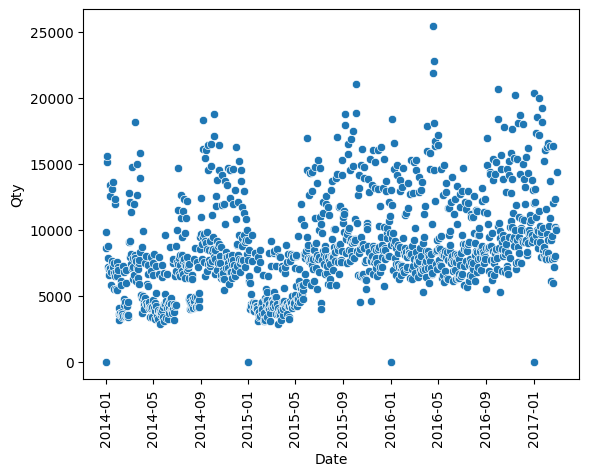

In [ ]:
sns.scatterplot(data=sales_tar, x='Date', y='Qty')
plt.xticks(rotation=90)
plt.show()

### 3) 휘발류 가격과 상품 판매량 추이 비교

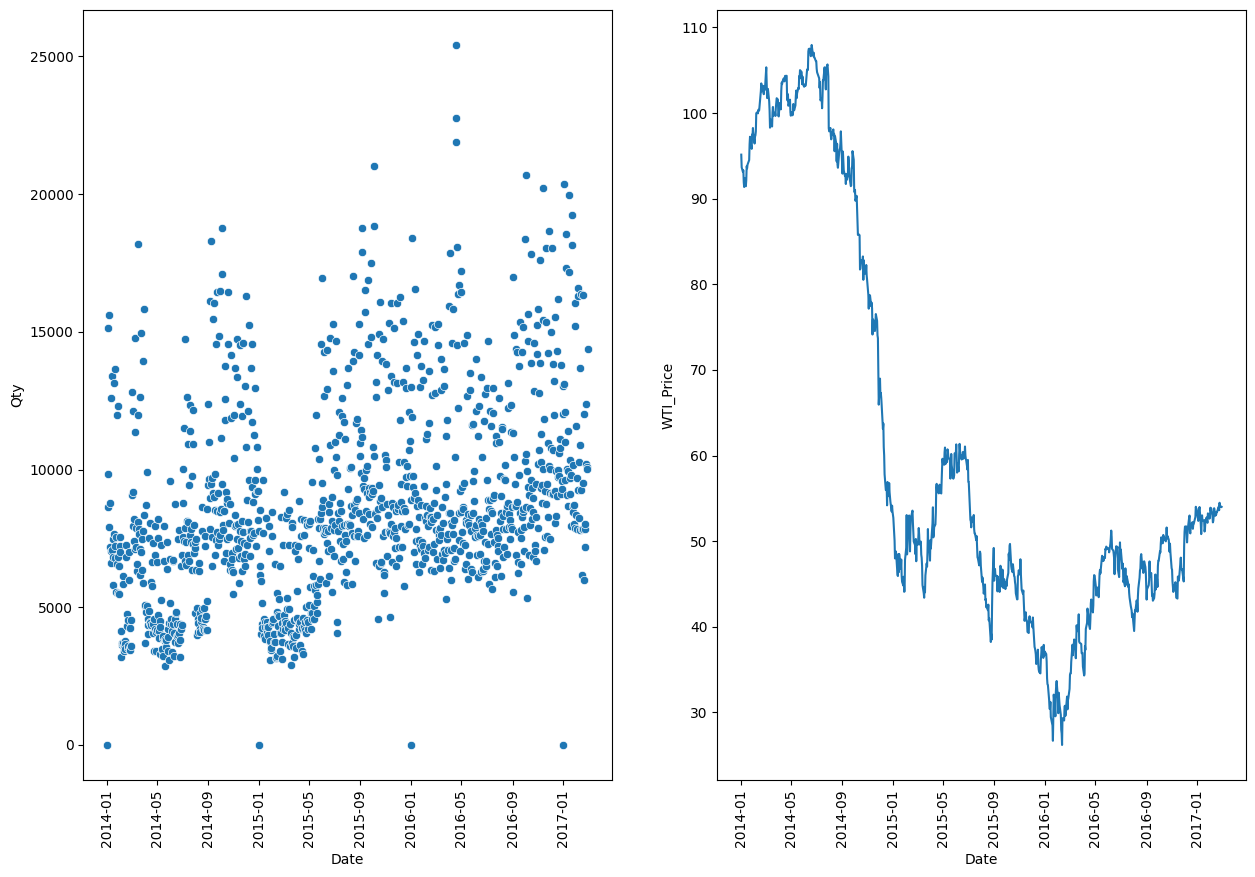

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.xticks(rotation=90)
sns.scatterplot(data=sales_tar, x='Date', y='Qty')

plt.subplot(1, 2, 2)
plt.xticks(rotation=90)
sns.lineplot(data=oil_price, x='Date', y='WTI_Price')
plt.show()

### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
orders_tar = df_order.loc[df_order['Store_ID'] == 44]
orders_tar


,Date,Store_ID,CustomerCount,City,State,Store_Type
42017,2014-01-02,44,4422,Saint Paul,\tMinnesota,1
42018,2014-01-03,44,4167,Saint Paul,\tMinnesota,1
42019,2014-01-04,44,5341,Saint Paul,\tMinnesota,1
42020,2014-01-05,44,5123,Saint Paul,\tMinnesota,1
42021,2014-01-06,44,3917,Saint Paul,\tMinnesota,1
...,...,...,...,...,...,...
43158,2017-02-24,44,4549,Saint Paul,\tMinnesota,1
43159,2017-02-25,44,4619,Saint Paul,\tMinnesota,1
43160,2017-02-26,44,3877,Saint Paul,\tMinnesota,1
43161,2017-02-27,44,3961,Saint Paul,\tMinnesota,1


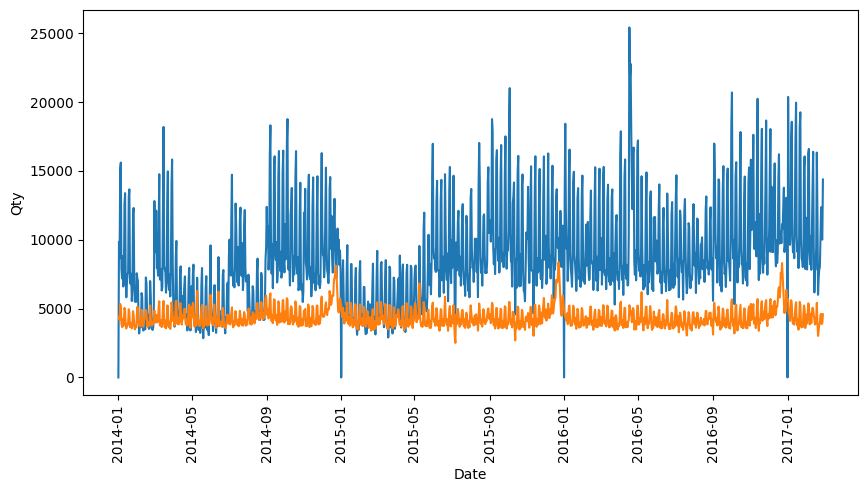

In [ ]:
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.xticks(rotation=90)
sns.lineplot(data=sales_tar, x='Date', y='Qty')

# plt.subplot(1, 2, 2)
plt.xticks(rotation=90)
sns.lineplot(data=orders_tar, x='Date', y='CustomerCount')
plt.show()

### -> 가설: 고객 수와 판매량의 변화추이가 비슷하다.

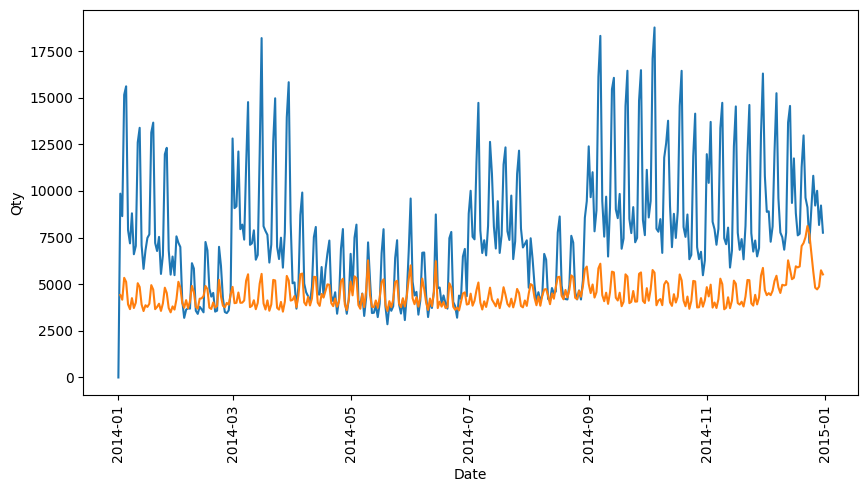

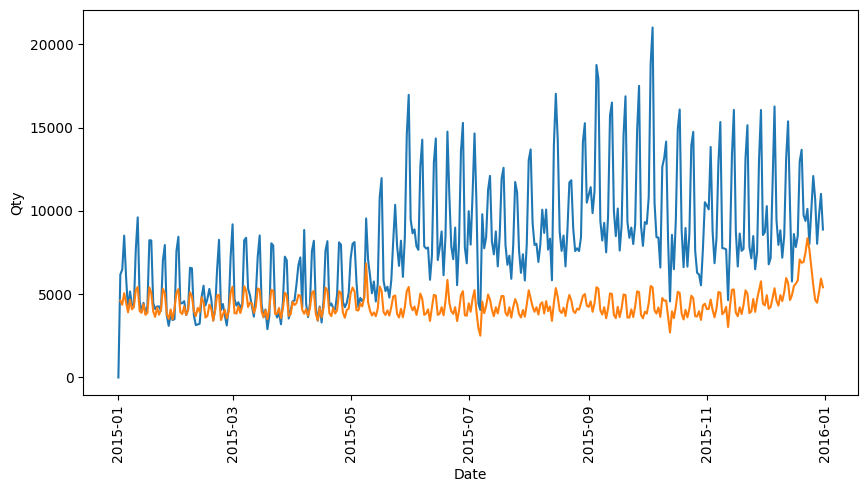

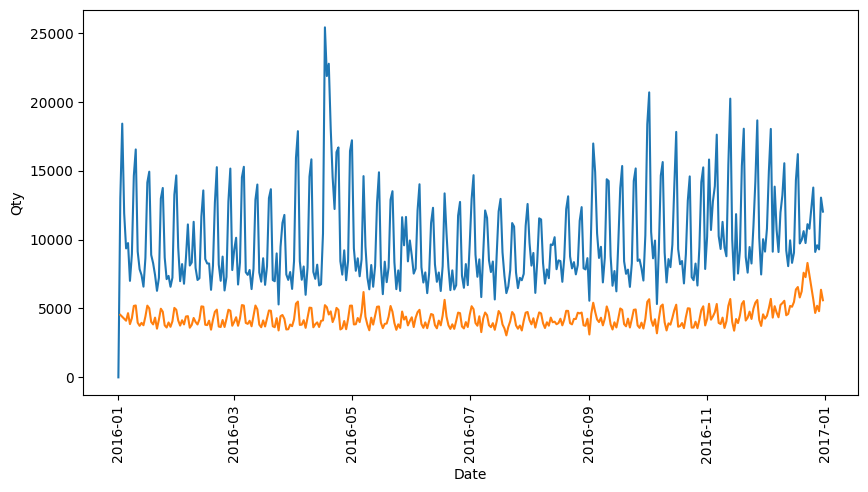

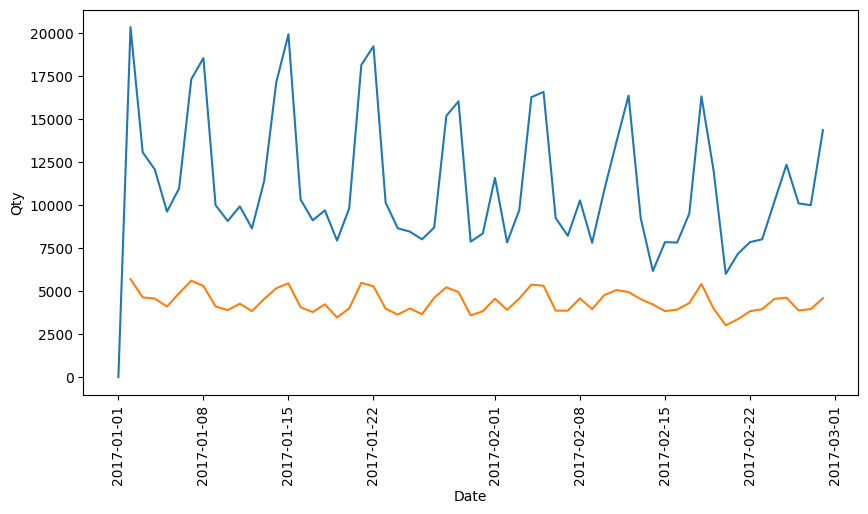

In [ ]:
# 그래프 확인
order_14 = orders_tar.loc[orders_tar['Date'].between('2014-01-01', '2014-12-31')]
sale_14 = sales_tar.loc[sales_tar['Date'].between('2014-01-01', '2014-12-31')]

order_15 = orders_tar.loc[orders_tar['Date'].between('2015-01-01', '2015-12-31')]
sale_15 = sales_tar.loc[sales_tar['Date'].between('2015-01-01', '2015-12-31')]

order_16 = orders_tar.loc[orders_tar['Date'].between('2016-01-01', '2016-12-31')]
sale_16 = sales_tar.loc[sales_tar['Date'].between('2016-01-01', '2016-12-31')]

order_17 = orders_tar.loc[orders_tar['Date'].between('2017-01-01', '2017-12-31')]
sale_17 = sales_tar.loc[sales_tar['Date'].between('2017-01-01', '2017-12-31')]

plt.figure(figsize=(10, 5))
sns.lineplot(data=sale_14, x='Date', y='Qty')
plt.xticks(rotation=90)
sns.lineplot(data=order_14, x='Date', y='CustomerCount')
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=sale_15, x='Date', y='Qty')
plt.xticks(rotation=90)
sns.lineplot(data=order_15, x='Date', y='CustomerCount')
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=sale_16, x='Date', y='Qty')
plt.xticks(rotation=90)
sns.lineplot(data=order_16, x='Date', y='CustomerCount')
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=sale_17, x='Date', y='Qty')
plt.xticks(rotation=90)
sns.lineplot(data=order_17, x='Date', y='CustomerCount')
plt.show()

In [ ]:
tmp = sales_tar[['Date', 'Qty']]
tmp2 = orders_tar[['Date', 'CustomerCount']]

tmp_merge = pd.merge(tmp, tmp2)
tmp_merge.drop('Date', axis=1, inplace=True)
tmp_merge.corr()

,Qty,CustomerCount
Qty,1.000000,0.589917
CustomerCount,0.589917,1.000000


## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

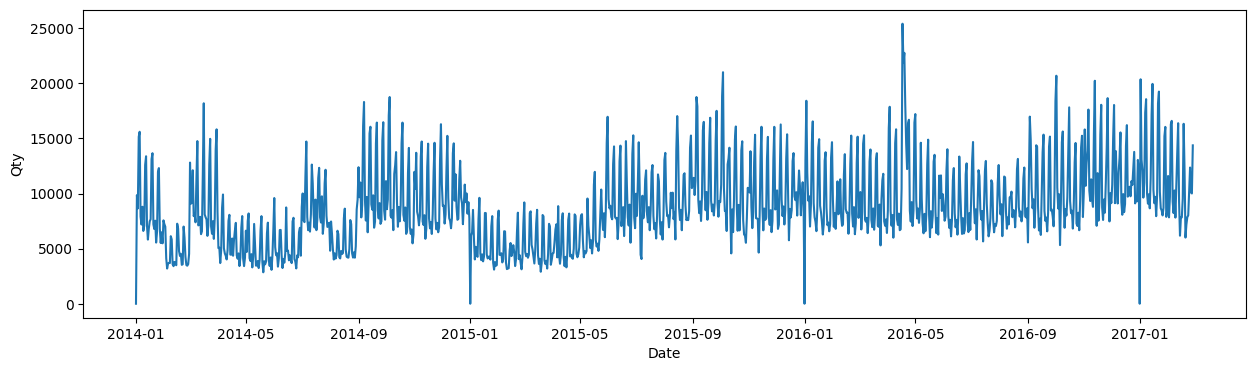

In [ ]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=sales_tar, x='Date', y='Qty')
plt.show()

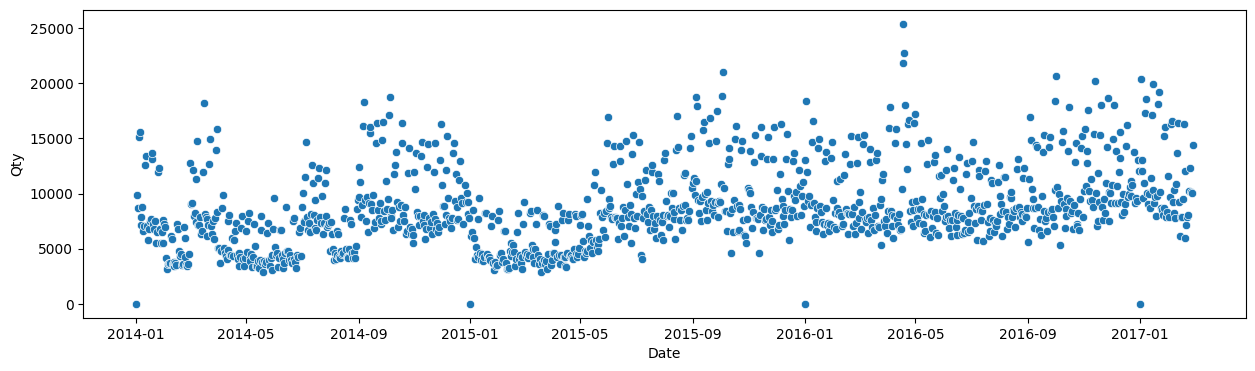

In [ ]:
plt.figure(figsize=(15, 4))
sns.scatterplot(data=sales_tar, x='Date', y='Qty')
plt.show()

### 2) 요일별 변화량 비교

In [ ]:
sales_tar['Weekday'] = sales_tar['Date'].dt.day_name()
sales_tar.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Weekday
43,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,Wednesday
97,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,Thursday
151,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,Friday
205,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,Saturday
259,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,Sunday


In [ ]:
sales_tar['Weekday'].value_counts()

Weekday
Wednesday    165
Saturday     165
Monday       165
Tuesday      165
Thursday     164
Friday       164
Sunday       164
Name: count, dtype: int64

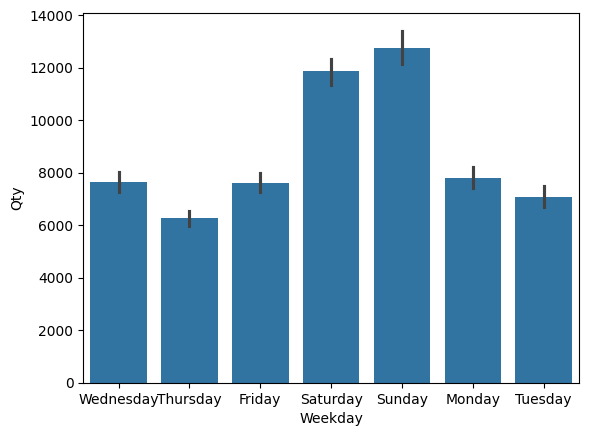

In [ ]:
sns.barplot(data=sales_tar, x='Weekday', y='Qty')
plt.show()

### -> 가설: 주말에 음료 판매량이 높다

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

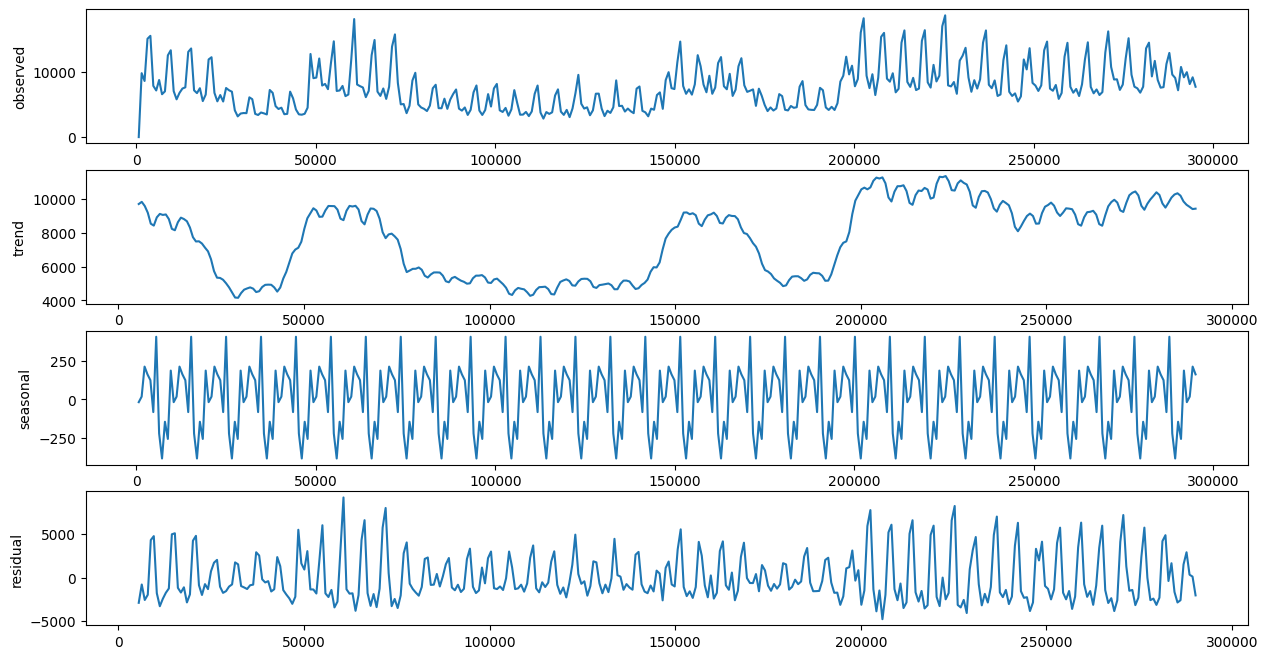

,observed,trend,seasonal,residual
645,0.0,NaN,-18.390222,NaN
1456,9853.0,NaN,17.680180,NaN
2267,8647.0,NaN,212.901445,NaN
3078,15153.0,NaN,162.359778,NaN
3889,15606.0,NaN,124.549433,NaN
...,...,...,...,...
291795,9216.0,NaN,187.004893,NaN
292606,10006.0,NaN,-18.390222,NaN
293417,8173.0,NaN,17.680180,NaN
294228,9218.0,NaN,212.901445,NaN


In [ ]:
decomp_plot(3, '2014-01-01', '2014-12-31', 12)

### 4) 그 외 패턴 찾아보기

### 계절별 (달)

### -> 가설: 날씨가 추울 수록 판매량이 많다...(?) (가을~겨울)

In [ ]:
sales_tar['month'] = sales_tar['Date'].dt.month
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# apply 함수를 사용하여 계절(season) 컬럼 추가
sales_tar['season'] = sales_tar['month'].apply(get_season)
sales_tar.head(300)

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,Weekday,month,season
43,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,Wednesday,1,Winter
97,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,Thursday,1,Winter
151,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,Friday,1,Winter
205,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,Saturday,1,Winter
259,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,Sunday,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
15973,2014-10-23,44,6337.0,3,DB001,Beverage,Drink,2,8,Thursday,10,Fall
16027,2014-10-24,44,6570.0,3,DB001,Beverage,Drink,2,8,Friday,10,Fall
16081,2014-10-25,44,11866.0,3,DB001,Beverage,Drink,2,8,Saturday,10,Fall
16135,2014-10-26,44,14142.0,3,DB001,Beverage,Drink,2,8,Sunday,10,Fall


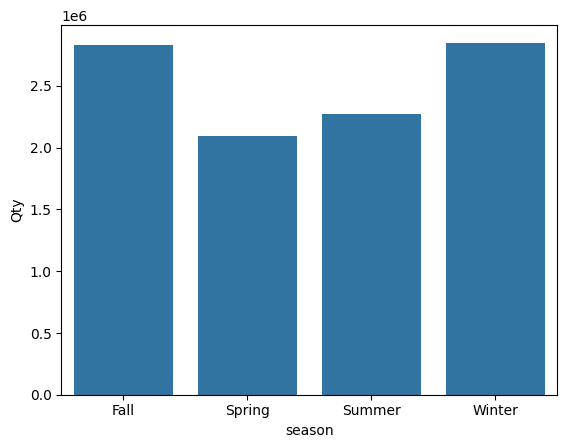

In [ ]:
season_df = sales_tar.groupby(['season'], as_index=False)['Qty'].sum()
sns.barplot(data=season_df, x='season', y='Qty')
plt.show()

### -> 겨울과 가을에 음료 판매량이 많다.

In [ ]:
season_df.head()

,season,Qty
0,Fall,2832996.0
1,Spring,2094976.0
2,Summer,2272256.0
3,Winter,2849508.0


In [ ]:
oil_price_2016 = oil_price.loc[oil_price['Date'].between('2015-01-01', '2016-05-31')]
sale_2016 = sales_tar.loc[sales_tar['Date'].between('2015-01-01', '2016-05-31')]


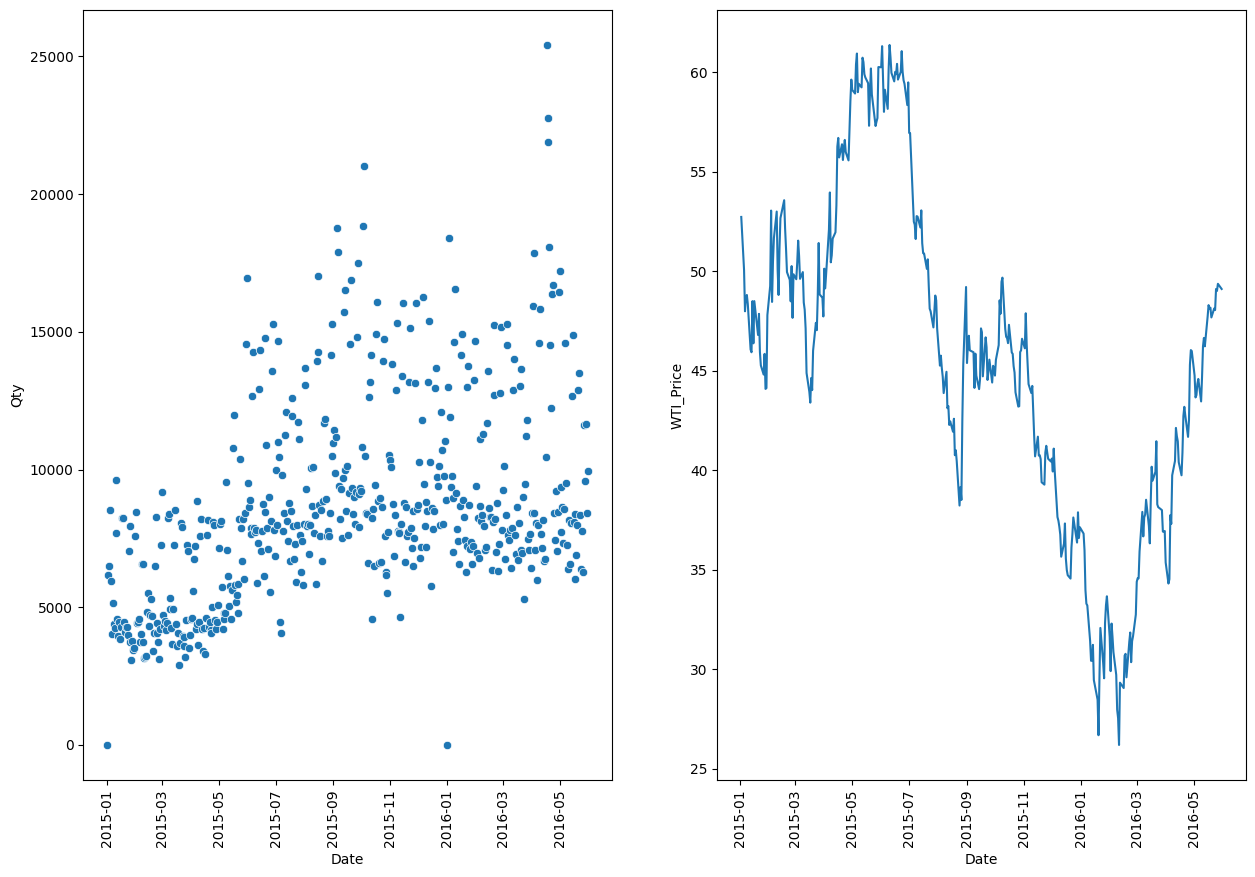

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.xticks(rotation=90)
sns.scatterplot(data=sale_2016, x='Date', y='Qty')

plt.subplot(1, 2, 2)
plt.xticks(rotation=90)
sns.lineplot(data=oil_price_2016, x='Date', y='WTI_Price')
plt.show()

### 2016/01~2016/05 유가가 가장 낮은 시기에 판매량이 높은 편..이다?..

In [ ]:
# 가설 정리
# 1. 고객 수와 판매량의 변화추이가 비슷하다.
# 2. 주말에 음료 판매량이 높다
# 3. 2016/01~2016/05 유가가 가장 낮은 시기에 판매량이 높은 편이다

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.